# SAS Pain Points
# And their Remedies with Python

Data analysis in SAS involves a range of frustrations.

In this presentation, we'll see how Python and tools in its ecosystem can resolve 3 common pain points.

# Pain Point 1
# In SAS, it’s not straightforward to run and compare many models
Example use case:
* run a few different regression models
* extract some model estimates
* create a summary table

## SAS

Pain point:
* extracting what you need from a `proc` (like `proc reg`) is cumbersome

<img align="left" src="img/reg1.png" >

Next, we'll create and run the regression macro.

Pain points:
* Macro syntax is powerful but clunky
* Using `%scan` and `%eval` is very verbose

<img align="left" src="img/reg2.png" >

Finally, we combine the output.

Pain points:
* Using length statements...
* Simple printing is very verbose

<img align="left" src="img/reg3.png" >

## With Python

Using a modern tool like Python is much easier.

In [1]:
# include some common code modules
import statsmodels.api as sm
import numpy as np
import pandas as pd

In [2]:
# in one line, we download a dataset and create a data frame
df = sm.datasets.get_rdataset("Guerry", "HistData").data

In [3]:
# printing is succinct
df.head()

,dept,Region,Department,Crime_pers,Crime_prop,Literacy,Donations,Infants,Suicides,MainCity,...,Crime_parents,Infanticide,Donation_clergy,Lottery,Desertion,Instruction,Prostitutes,Distance,Area,Pop1831
0,1,E,Ain,28870,15890,37,5098,33120,35039,2:Med,...,71,60,69,41,55,46,13,218.372,5762,346.03
1,2,N,Aisne,26226,5521,51,8901,14572,12831,2:Med,...,4,82,36,38,82,24,327,65.945,7369,513.00
2,3,C,Allier,26747,7925,13,10973,17044,114121,2:Med,...,46,42,76,66,16,85,34,161.927,7340,298.26
3,4,E,Basses-Alpes,12935,7289,46,2733,23018,14238,1:Sm,...,70,12,37,80,32,29,2,351.399,6925,155.90
4,5,E,Hautes-Alpes,17488,8174,69,6962,23076,16171,1:Sm,...,22,23,64,79,35,7,1,320.280,5549,129.10


### Running one regression model
Requires 4 lines of code - including the data manipulation.

In [4]:
# clean way to specify base variables
base_vars = ['Distance', 'Literacy', 'Wealth']

In [5]:
X = df[base_vars]
y = df['Lottery']

In [6]:
regression = sm.OLS(y, X).fit()

In [7]:
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Lottery   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     104.7
Date:                Wed, 16 Nov 2016   Prob (F-statistic):           3.96e-28
Time:                        16:20:15   Log-Likelihood:                -391.29
No. Observations:                  86   AIC:                             788.6
Df Residuals:                      83   BIC:                             795.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Distance       0.0584      0.022      2.595      0.011         0.014     0.103
Literacy       0.1115      0.093      1.196      0.235        -0.074     0.297
Wealth         0.5664      0.102      5.551      0.000         0.363     0.769
==============================================================================
Omnibus:                        6.220   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                6.414
Skew:                          -0.651   Prob(JB):                       0.0405
Kurtosis:                       2.691   Cond. No.                         10.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Running bulk regression in Python

In [8]:
# (base vars as above)
base_vars = ['Distance', 'Literacy', 'Wealth']

In [9]:
# add one of these at a time, to model containing `base_vars`
vars = ['Crime_pers', 'Crime_prop', 'Commerce', 'Area', 'Pop1831', 'Instruction']

In [10]:
# much of this code is self-documenting: it's clear what is going on

# for storing combined data 
combined_data = []

for i in range(len(vars)):
    
    predictors = base_vars + [vars[i]]
    
    X = df[predictors]
    y = df['Lottery']

    # one line of code to fit an OLS regression model
    regression = sm.OLS(y, X).fit()

    # use a pandas (pd) function to create a data frame
    summary = pd.DataFrame(
        {
            'Model': i+1,  # yes, python has 0-base indexing
            'coefficient': regression.params,
            'error' :regression.bse,
            't': regression.tvalues,
            'p-value': regression.pvalues
        },
        # pandas uses an index column
        index=regression.params.index)

    # append each result `summary` table (we'll have 6 of these)
    combined_data.append(summary)

In [11]:
# convert output data to a pandas data frame
combined_df = pd.concat(combined_data)

In [12]:
combined_df.head(10)

,Model,coefficient,error,p-value,t
Distance,1,0.060921,0.021029,0.004830,2.896940
Literacy,1,-0.141700,0.111717,0.208249,-1.268388
Wealth,1,0.428025,0.102673,0.000075,4.168800
Crime_pers,1,0.000864,0.000239,0.000506,3.621784
Distance,2,0.029791,0.022055,0.180477,1.350794
Literacy,2,-0.019217,0.092519,0.835974,-0.207705
Wealth,2,0.338218,0.111020,0.003114,3.046464
Crime_prop,2,0.002846,0.000731,0.000200,3.893559
Distance,3,0.025131,0.023321,0.284360,1.077627
Literacy,3,0.133158,0.088046,0.134284,1.512372


## Extra: Extending this with Python Pipelines

In SAS, combining different *algorithms* would require lots of code, which would have to be heavily restructured for each new algorithm.

The Python Pipeline is a lightweight tool for such heavy-duty tasks.

```python
# create data
X = np.random.randn(20, 40)
y = np.random.randn(20)

# define 3 steps in our pipeline
pipeline = Pipeline(
    [
        ('scaling', StandardScaler()),
        ('pca', PCA(n_components=5)),
        ('lm', LinearRegression())
    ]
)

# run the pipeline 
pipe = pipeline.fit(X, y)
```

# Pain Point 2
# SAS is not conducive to exploratory data analysis

In data analysis, you need to know your data well. You want the software to help you easily explore your data.

Example use case:
* load some external data
* create a few graphics
* do some data manipulation
* export data to CSV

## SAS

Pain points:
* Viewing the plots requires switching to HTML output
* Merging requires sorting (!)
* Useful functionality is missing or hard to implement (e.g., rows/columns of dataset)

<img align="left" src="img/pain2.png" >

## Exploratory data analysis with Python

Syntax is clean, graphics are in-line, and code is much more logical. You don't need `run`, `quit`, nor the semicolon!

In [13]:
%matplotlib inline
import pandas as pd
import seaborn as sns

/Users/pawel/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [14]:
# read in data
tips = pd.read_csv('data/tips.csv')

In [15]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


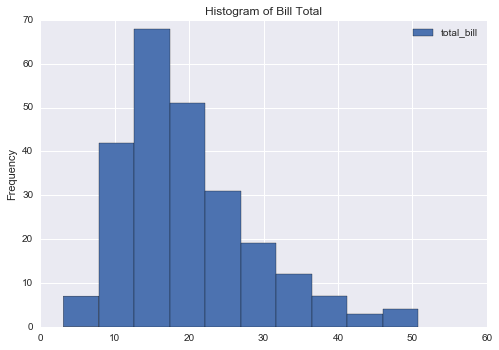

In [16]:
# you can easily obtain plots, which appear in-line
tips.plot(y="total_bill", kind="hist", title="Histogram of Bill Total");

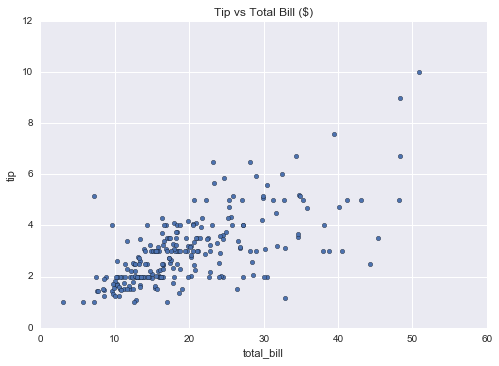

In [17]:
tips.plot(x="total_bill", y="tip", kind="scatter", title="Tip vs Total Bill ($)");

In [18]:
# create a new variable
tips = tips.assign(idvar=range(tips.shape[0]))

In [19]:
# more data manipulation
small_groups = tips.query("size < 4")

small_groups = small_groups.assign(small_group = True)

In [20]:
# example merge
merged = pd.merge(tips,
                  small_groups[['idvar', 'small_group']],
                  on='idvar',
                  how='left'
                 )

In [21]:
merged.head()

,total_bill,tip,sex,smoker,day,time,size,idvar,small_group
0,16.99,1.01,Female,No,Sun,Dinner,2,0,True
1,10.34,1.66,Male,No,Sun,Dinner,3,1,True
2,21.01,3.50,Male,No,Sun,Dinner,3,2,True
3,23.68,3.31,Male,No,Sun,Dinner,2,3,True
4,24.59,3.61,Female,No,Sun,Dinner,4,4,NaN


In [22]:
# how many rows and columns in `merged`? (How to do this in SAS?)
merged.shape

(244, 9)

In [23]:
# save as CSV
tips.to_csv('tips2.csv')

### Side-by-side code comparison

<img align="left" src="img/compared.png" >

# Pain Point 3
# SAS lacks modern features for data analysis

The list is extensive:

* SAS has no clean interface for quick data exploration
* SAS doesn't have a real interactive mode (like a console). Even in basic SAS GUI, all output is in a separate window from the code
* SAS GUI design leaves a lot to be desired
* There is no Mac version
* SAS is not free

The Python ecosystem solves all of the above pain points.

## One More Thing: Finding Help


Here is an example SAS paper (from Lex Jansen):

![lex](img/lex_jansen1.png)

## Better Help with Stack Overflow and Github

Stack Overflow is the current standard for finding help. And if you need example code, Github can't be beat.

The Python community is extremely active on both, in stark contrast to SAS, as shown next.

In [24]:
import numpy as np

stack_tags = pd.DataFrame(np.array([[639996, 155174, 6965], [689219, 84634, 402]]),
                          columns=["Python", "R", "SAS"],
                          index=["Stack Overflow", "Github"]
                         )

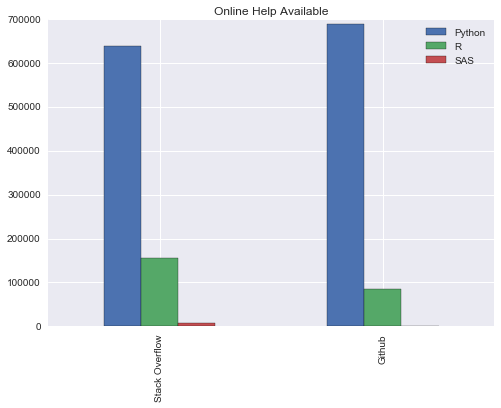

In [25]:
stack_tags.plot.bar(title="Online Help Available");

# Summary
# Python Solves Many SAS Pain Points
Data Analysis in SAS is clunky. Here are three pain points solved with Python and its ecosystem:

1. Running and comparing many models is easy with Python and its Pipeline.
2. Python syntax is conducive to quick data exploration.
3. The Python ecosystem makes it easy and enjoyable to perform an analysis and share it, and find useful help when needed.

# References

**To install and use this notebook interactively**, see here: https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/

Documentation for the regression example data (Guerry) http://vincentarelbundock.github.io/Rdatasets/doc/HistData/Guerry.html

Bulk Regression in SAS (PDF) http://www.lexjansen.com/nesug/nesug12/sa/sa15.pdf

Images of code use the [Solarized theme (light)](http://ethanschoonover.com/solarized) inside Emacs.